   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species  \
0   1            5.1           3.5            1.4           0.2  Iris-setosa   
1   2            4.9           3.0            1.4           0.2  Iris-setosa   
2   3            4.7           3.2            1.3           0.2  Iris-setosa   
3   4            4.6           3.1            1.5           0.2  Iris-setosa   
4   5            5.0           3.6            1.4           0.2  Iris-setosa   

       PCA1      PCA2  Cluster  
0 -2.816339  0.506051        1  
1 -2.645527 -0.651799        1  
2 -2.879481 -0.321036        1  
3 -2.810934 -0.577363        1  
4 -2.879884  0.670468        1  


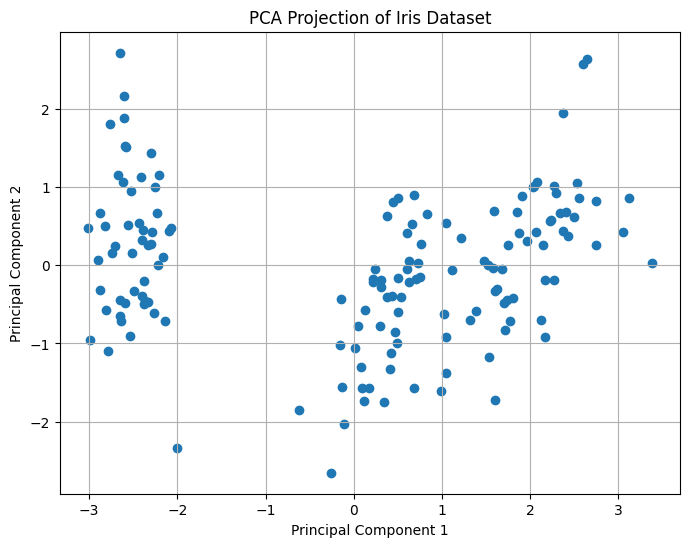

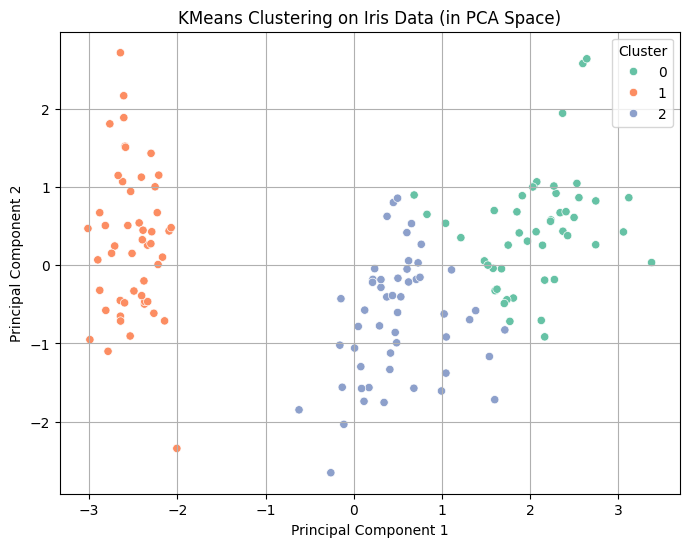

In [3]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load iris.csv
iris_df = pd.read_csv('Iris.csv')

# Step 2: Select only numerical features (ignore species column for clustering)
features = iris_df.select_dtypes(include=[np.number])

# Step 3: Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 4: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Step 5: Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Step 6: Add PCA and cluster info to DataFrame
iris_df['PCA1'] = pca_result[:, 0]
iris_df['PCA2'] = pca_result[:, 1]
iris_df['Cluster'] = clusters

# Step 7: Save results to SQLite
conn = sqlite3.connect('database.sqlite')
iris_df.to_sql('iris_clusters', conn, if_exists='replace', index=False)

# Optional: Read back from database to confirm
df_from_db = pd.read_sql_query("SELECT * FROM iris_clusters", conn)
print(df_from_db.head())

# PCA Only Visualization (Colored by actual species if present)
plt.figure(figsize=(8, 6))
if 'species' in iris_df.columns:
    sns.scatterplot(x=iris_df['PCA1'], y=iris_df['PCA2'], hue=iris_df['species'], palette='Set1')
    plt.title('PCA Projection of Iris Dataset (Colored by Species)')
else:
    plt.scatter(iris_df['PCA1'], iris_df['PCA2'])
    plt.title('PCA Projection of Iris Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# KMeans Clustering Visualization (Colored by Cluster label)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=iris_df['PCA1'], y=iris_df['PCA2'], hue=iris_df['Cluster'], palette='Set2')
plt.title('KMeans Clustering on Iris Data (in PCA Space)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

"""
Multivariate analysis involves examining multiple variables simultaneously to understand patterns and relationships.

PCA (Principal Component Analysis) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while retaining most of the variance.

KMeans is an unsupervised clustering algorithm that groups data based on similarity, minimizing intra-cluster distance.

PySpark is a Python API for Apache Spark, used for handling and processing big data in a distributed computing environment. It allows scalable preprocessing and machine learning using Spark MLlib.

SQLite is a lightweight relational database system used to store structured data locally without requiring a server. Ideal for saving results of data analysis and querying outputs.

PCA helps in visualizing complex datasets, while KMeans aids in identifying natural groupings or clusters.

Combining PCA with KMeans allows better visualization and clustering by reducing dimensions before clustering.

PySpark handles data at scale, while SQLite stores the final results compactly for further inspection or use.

PySpark Use:

Efficient handling of large datasets.

Schema inference and distributed computation.

Optional use here (for small datasets, Pandas is enough).

SQLite Use:

Lightweight, local database.

Used to store PCA + clustering output for further querying or reporting.

"""


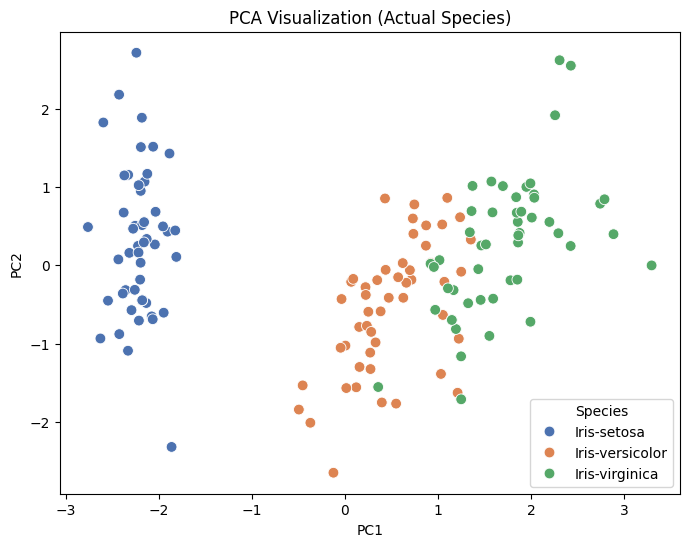

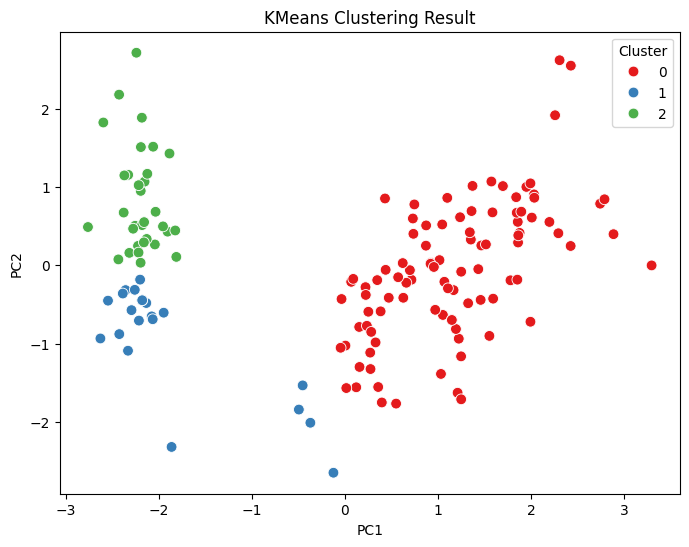

In [8]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Start Spark session
spark = SparkSession.builder.appName("IrisPCA_KMeans").getOrCreate()

# Load iris.csv into Spark
df_spark = spark.read.csv("Iris.csv", header=True, inferSchema=True)

# Select numeric columns and species
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'] # Updated column names
df_selected = df_spark.select(features + ['Species']) # Updated column name for 'species'

# Assemble into feature vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vector = assembler.transform(df_selected)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Convert to Pandas for PCA and KMeans
scaled_data = df_scaled.select("scaledFeatures", "species").rdd.map(lambda row: (row[0].toArray(), row[1])).collect()
scaled_features, species = zip(*scaled_data)
scaled_df = pd.DataFrame(scaled_features, columns=features)
species = pd.Series(species)

# Apply PCA (2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["Species"] = species

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)
pca_df["Cluster"] = clusters

# Plot 1: PCA colored by actual species
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Species", palette="deep", s=60)
plt.title("PCA Visualization (Actual Species)")
plt.show()

# Plot 2: KMeans clustering output
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set1", s=60)
plt.title("KMeans Clustering Result")
plt.show()
